In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras.models import load_model
from keras.utils import multi_gpu_model
import argparse
from matplotlib import pyplot as plt
from IPython.display import clear_output

from keras.callbacks import ModelCheckpoint
from datetime import datetime

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


train
 (50000, 32, 32, 3) (50000, 1)
(25000, 32, 32, 3) (25000, 1)
test
 (10000, 32, 32, 3) (10000, 1)
(5000, 32, 32, 3) (5000, 1)


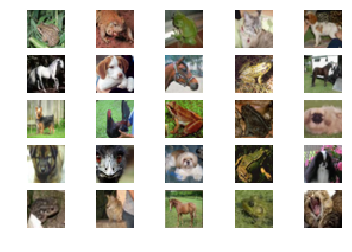

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
 
shrink_data = True
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if shrink_data:
    selected_classes = [2, 3, 5, 6, 7]
    print('train\n', x_train.shape, y_train.shape)
    x = [ex for ex, ey in zip(x_train, y_train) if ey in selected_classes]
    y = [selected_classes.index(ey) for ex, ey in zip(x_train, y_train) if ey in selected_classes]
    x_train = np.stack(x)
    y_train = np.stack(y).reshape(-1,1)
    print(x_train.shape, y_train.shape)

    print('test\n', x_test.shape, y_test.shape)
    x = [ex for ex, ey in zip(x_test, y_test) if ey in selected_classes]
    y = [selected_classes.index(ey) for ex, ey in zip(x_test, y_test) if ey in selected_classes]
    x_test = np.stack(x)
    y_test = np.stack(y).reshape(-1,1)
    print(x_test.shape, y_test.shape)
    num_classes = len(selected_classes)
else:
    print('train\n', x_train.shape, y_train.shape)
    print('test\n', x_test.shape, y_test.shape)
    num_classes = 10

# show some images
plt.figure(1)
for i in range (1,26):
    ax = plt.subplot(5,5,i)
    ax.axis('off')
    ax.imshow(x[i].reshape(32,32,3))
plt.show()

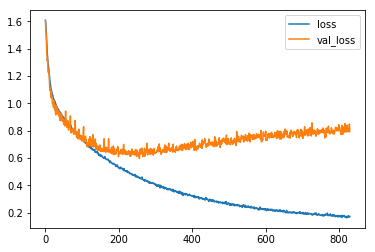

Epoch 00830: val_loss did not improve
22500/22500 [==============================] - 4s 187us/step - loss: 0.1710 - acc: 0.9415 - val_loss: 0.7971 - val_acc: 0.7936
Epoch 831/896
 5376/22500 [======>.......................] - ETA: 3s - loss: 0.1564 - acc: 0.9457

KeyboardInterrupt: 

In [3]:
batch_size = 256
epochs = 896

# The data, shuffled and split between train and test sets:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#1
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
               input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#2
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#3
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#4  # residual function (identity shortcut)
# net = conv + net
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))#we can change this number
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255



# # checkpoint

date=datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

outputFolder = './output-cnn/'+date+'/'
if not os.path.exists(outputFolder):
         os.makedirs(outputFolder)
filepath=outputFolder+"/weights-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpointer = ModelCheckpoint(filepath=filepath, verbose=1,period=10, save_best_only=True) #save_weights_only=True ,save_best_only=False
                                                                                            #mode='auto', period=10

model.fit(x_train, y_train,  # this is our training examples & labels
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1,  # this parameter control the % of train data used for validation
          shuffle=True,
          callbacks=[plot_losses,checkpointer])  # this prints our loss at the end of every epoch

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('==> Test loss:', scores[0])
print('==> Test accuracy:', scores[1])



In [4]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('==> Test loss:', scores[0])
print('==> Test accuracy:', scores[1])

5000/5000 [==============================] - 1s 156us/step
==> Test loss: 0.9241990633010865
==> Test accuracy: 0.6332


In [5]:
model.save('/home/project67/Tomer_Learning/model.h5')

# Prediction Example

(32, 32, 3)


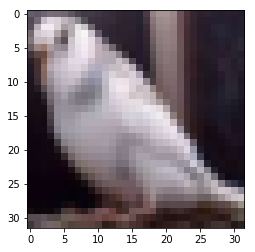

In [9]:
img = x_test[80]
label = np.argmax(y_test[80])
print(img.shape)
plt.imshow(img)

In [10]:
prediction = model.predict(img[np.newaxis,...])
prediction = np.argmax(prediction)
print('model prediction: {}'.format(prediction))
print('ground truth: {}'.format(label))
if prediction == label: print('great! we got it right')

model prediction: 0
ground truth: 0
great! we got it right
